In [1]:
import sys
import os
import subprocess
import tarfile
import shutil

import torch

import boda

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn

In [2]:
import os
import random
from tqdm import tqdm
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, 
                              DataLoader, TensorDataset)
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
from torchsummary import summary
from functools import partial
import pytorch_lightning as pl
from pytorch_lightning.metrics import functional
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import time
import scipy.stats as stats
import seaborn as sns
import arviz as az

In [3]:
unpack_artifact('gs://syrgoth/aip_ui_test/model_artifacts__20210515_230601__116249.tar.gz')

model_dir = './artifacts'

my_model = model_fn(model_dir)

Loaded model from 20210515_230601 in eval mode


In [4]:
my_model.cuda()

BassetVL(
  (pad1): ConstantPad1d(padding=[9, 9], value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=[5, 5], value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=[3, 3], value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in_featu

In [5]:
my_model(torch.randn(10,4,600).cuda())

tensor([[16.0990, 16.0224, 25.6702],
        [10.3606, 11.1581, 19.5244],
        [12.3604, 14.0390, 23.6827],
        [13.4357, 11.4906, 18.9060],
        [ 9.4216,  8.8093, 16.5846],
        [11.8236, 13.5092, 20.9574],
        [12.7955, 12.3831, 21.1068],
        [10.0806, 11.2934, 20.0757],
        [12.6273, 12.3974, 21.1180],
        [15.1385, 14.6698, 23.5958]], device='cuda:0', grad_fn=<AddmmBackward>)

## Plot metrics

In [6]:
def Shannon_entropy(x):
    p_c = nn.Softmax(dim=1)(x)
    return torch.sum(- p_c * torch.log(p_c), axis=1)

def entropy(X):
    p_c = F.softmax(torch.tensor(X, dtype=torch.float64), dim=1).numpy()
    shannon = np.sum(- p_c * np.log(p_c), axis=1)
    return 1 - shannon / np.log(X.shape[1])

def get_predictions(model, datamodule, dataset='val'):
    if dataset=='train':
        data_generator = datamodule.train_dataloader()
    elif dataset=='val':
        data_generator = datamodule.val_dataloader()
    elif dataset=='test':
        data_generator = datamodule.test_dataloader()
    model.eval()
    truths = []
    preds = []
    if next(model.parameters()).is_cuda:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch.cuda()).cpu().detach().numpy())
            truths.append(local_targets.numpy())
    else:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch).detach().numpy())
            truths.append(local_targets.numpy())
    preds_array = np.concatenate(preds, axis=0)
    truths_array = np.concatenate(truths, axis=0)
    '''
    #Unscale:
    if datamodule.rescale is not None:
        a, b = datamodule.rescale
        mins, maxs = datamodule.activity_mins.numpy(), datamodule.activity_maxs.numpy()
        truths_array = (truths_array - a) * (maxs - mins) / (b - a) + mins 
        preds_array = (preds_array - a) * (maxs - mins) / (b - a) + mins 
    #Unnormalize:
    if datamodule.normalize:
        stds = datamodule.activity_stds.numpy()
        means = datamodule.activity_means.numpy()
        truths_array = truths_array * stds + means
        preds_array = preds_array * stds + means
    '''
    return truths_array, preds_array

def get_scatterplots(truths_array, preds_array):
    fig = plt.figure(figsize=(20,6))
    celltypes = ['K562', 'HepG2', 'SKNSH']
    pearsons = []
    spearmans = []
    for dim in range(3):
        plt.subplot(1, 3, dim+1)
        pearson = stats.pearsonr(truths_array[:,dim], preds_array[:,dim])[0]
        pearsons.append(pearson)
        spearman = stats.spearmanr(truths_array[:,dim], preds_array[:,dim])[0]
        spearmans.append(spearman)
        sns.scatterplot(x=truths_array[:,dim], y=preds_array[:,dim], color='C'+str(dim))
        plt.xlabel('True values')
        plt.ylabel('Predicted values')
        lim_min = min( (truths_array[:,dim]).min(), (preds_array[:,dim]).min() ) - 0.1
        lim_max = max( (truths_array[:,dim]).max(), (preds_array[:,dim]).max() ) + 0.1
        plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
        plt.xlim(lim_min, lim_max)
        plt.ylim(lim_min, lim_max)
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.title(f'{celltypes[dim]} | Spearman {round(spearman, 2)}, Pearson {round(pearson, 2)}')
    plt.draw()
    print('')
    print('----------------------------------------------')
    print(f'Pearsons: {pearsons}, average: {round(np.mean(pearsons), 2)}')
    print(f'Spearmans: {spearmans}, average: {round(np.mean(pearsons), 2)}')
    print('----------------------------------------------')

def get_specificity_corr(truths_array, preds_array, specificity_fn):
    fig = plt.figure(figsize=(6,6))
    specificity_truths = specificity_fn(truths_array)
    specificity_preds = specificity_fn(preds_array)
    specificity_pearson = stats.pearsonr(specificity_truths, specificity_preds)[0]
    specificity_spearman = stats.spearmanr(specificity_truths, specificity_preds)[0]
    sns.scatterplot(x=specificity_truths, y=specificity_preds, color='C6')
    plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', alpha=0.75)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'Specificity | Spearman {round(specificity_spearman, 2)}, Pearson {round(specificity_pearson, 2)}')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.draw()

In [7]:
datamodule = boda.data.BODA2_DataModule(datafile_path='gs://syrgoth/data/BODA.MPRA.txt',
                     sequence_column='nt.sequence',
                     activity_columns=['K562', 'HepG2.neon', 'SKNSH'],
                     valid_pct=5,
                     test_pct=5,
                     batch_size=32,
                     padded_seq_len=600, 
                     num_workers=1)
datamodule.setup()

Padding sequences and converting to one-hot tensors...
10000/27719 sequences padded and tokenized...
20000/27719 sequences padded and tokenized...


In [8]:
val_loader = datamodule.val_dataloader()

In [9]:
val_res = []
for batch in val_loader:
    val_res.append( [my_model(batch[0].cuda()).cpu().detach(), batch[1]] )
    
res = []
for value in zip(*val_res):
    res.append( torch.cat(value,dim=0) )
    
preds, labs = res
del val_res
del res

In [10]:
boda.graph.utils.Pearson_correlation(labs, preds)

(tensor([0.4171, 0.3965, 0.4274]), tensor(0.4137))


----------------------------------------------
Pearsons: [0.41713067458286507, 0.3965317716524767, 0.42736307871811474], average: 0.41
Spearmans: [0.33390510771199816, 0.3336594111285791, 0.3647073768867971], average: 0.41
----------------------------------------------


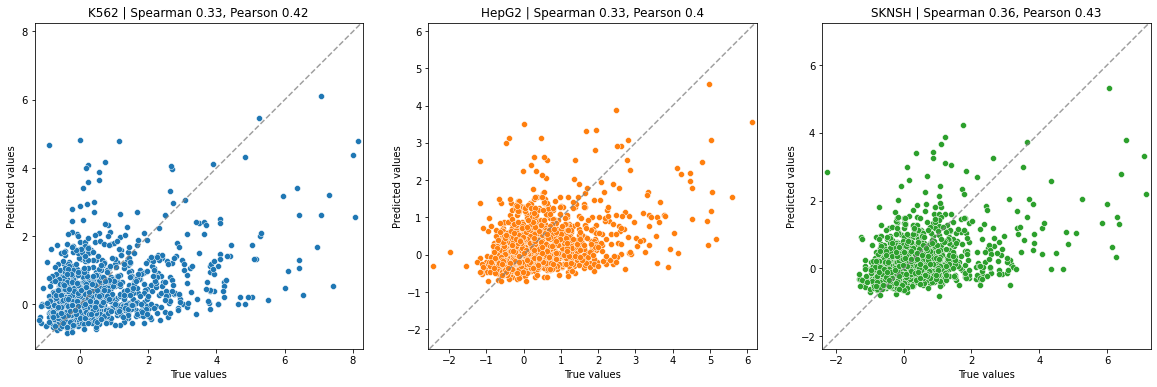

In [11]:
get_scatterplots(labs, preds)


----------------------------------------------
Pearsons: [0.9343370892559246, 0.904719082179215, 0.9079129601153859], average: 0.92
Spearmans: [0.8581414710148799, 0.8511879086905736, 0.8297198155877946], average: 0.92
----------------------------------------------

----------------------------------------------
Pearsons: [0.41713067458286507, 0.3965317716524767, 0.42736307871811474], average: 0.41
Spearmans: [0.33390510771199816, 0.3336594111285791, 0.3647073768867971], average: 0.41
----------------------------------------------


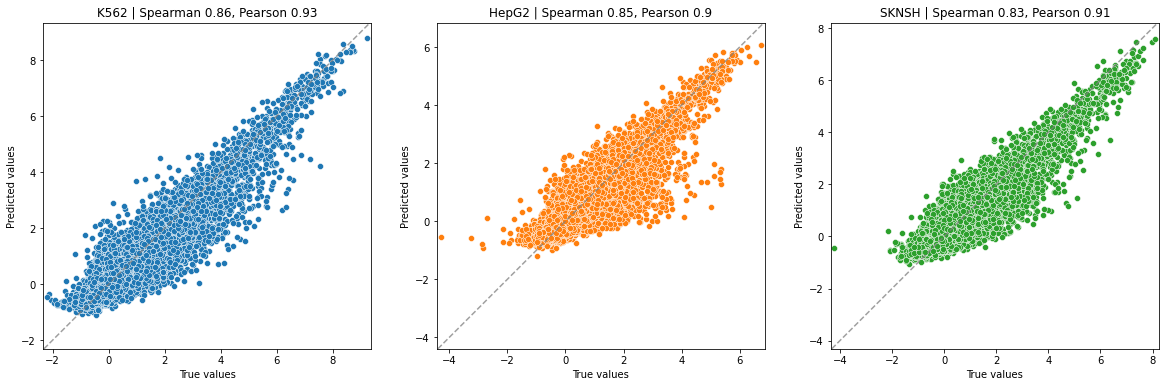

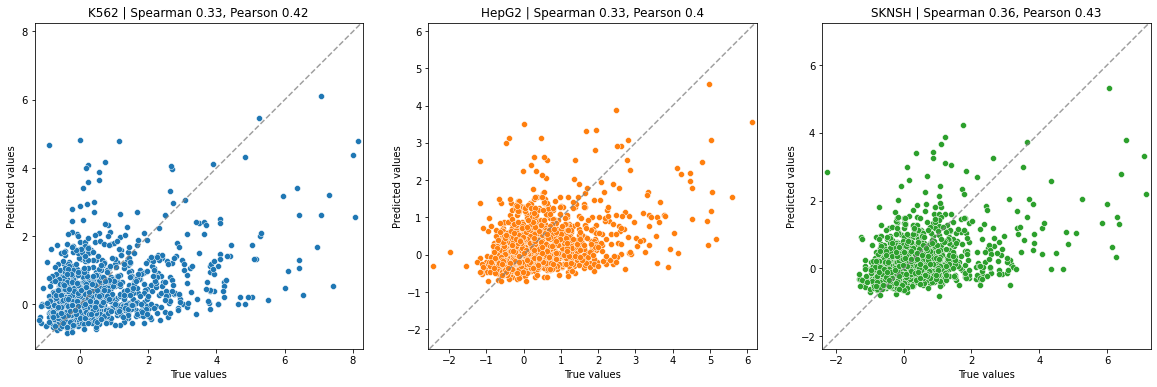

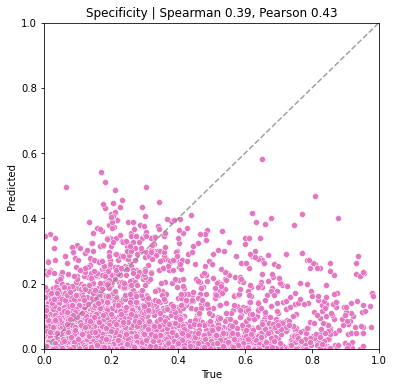

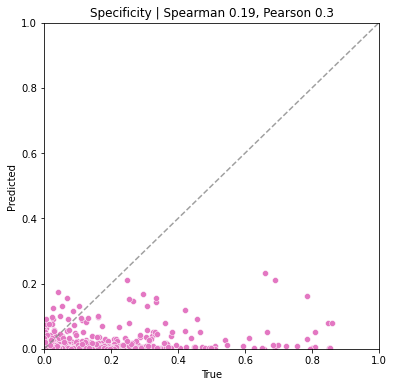

In [12]:
train_truths, train_preds = get_predictions(my_model, datamodule, dataset='train')
val_truths, val_preds = get_predictions(my_model, datamodule, dataset='val')
get_scatterplots(train_truths, train_preds)
get_scatterplots(val_truths, val_preds)
get_specificity_corr(train_truths, train_preds, specificity_fn=entropy)
get_specificity_corr(val_truths, val_preds, specificity_fn=entropy)